In [30]:
from graphstats import sbm
from graspy.embed import OmnibusEmbed
from graspy.embed import AdjacencySpectralEmbed
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

The goal of this notebook is to compare A_Bar, Omni_bar, and JRDPG as estimates of the underlying probability matrix. In particular, I want to consider generating matrices of the form
$$ H \Lambda^{i} H^{T} $$ where $ \Lambda^{i} = \Lambda + \epsilon_{i} $ and $ \epsilon_{i} = diag(e_{1}, .., e_{d}) $ where $ e_{i} \sim N(0, \sigma^{2}) $. Here, the setting with $ \sigma^{2} = 0 $ is the setting in which $ \bar{A} $ should "win" (in terms of MSE). Small $ \sigma^{2} $ should favor $ \widehat{Omni} $ and larger $ \sigma^{2} $ should favor JRDPG.

We first consider a 2-block model $ n = 100 $, $ M = 2 $, $ \pi_{1} = \pi_{2} = 0.5 $

In [53]:
np.random.seed(1)

n = 50
pi1 = 0.5
pi2 = 1 - pi1
pis = np.array([pi1, pi2])
pi = pis

H = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(3)]])
L = [0.5, 0.5]
P = H @ np.diag(L) @ H.T

sigmas = np.arange(0.2, step = 0.01)

it = 10
abarSE = [[] for s in sigmas]
omniSE = [[] for s in sigmas]
omnibarSE = [[] for s in sigmas]

for i, s in enumerate(tqdm(sigmas)):
    for j in range(it):
        E1 = np.random.normal(0, s, 2)
        E2 = np.random.normal(0, s, 2)
        
        L1 = np.diag(L + E1)
        L2 = np.diag(L + E2)
        
        P1 = H @ L1 @ H.T
        P2 = H @ L2 @ H.T
        
        A1 = sbm.adj_matrix(n = n, Lambda = P1, pi = pi, acorn = int(i*j + i))
        A2 = sbm.adj_matrix(n = n, Lambda = P2, pi = pi, acorn = int(i*j + 2*(i + j + 1)))
        
        omni_object = OmnibusEmbed()
        Zhat = omni_object.fit_transform([A1, A2])
        Zhat_means1 = np.array([np.mean(Zhat[0][:int(n/2)], axis = 0), np.mean(Zhat[0][int(n/2):], axis = 0)])
        P1_omni = Zhat_means1 @ Zhat_means1.T
        
        Zhat_means2 = np.array([np.mean(Zhat[1][:int(n/2)], axis = 0), np.mean(Zhat[1][int(n/2):], axis = 0)])
        P2_omni = Zhat_means2 @ Zhat_means2.T
        omniSE[i].append((np.linalg.norm(P1_omni - P)**2 + np.linalg.norm(P2_omni - P)**2)/2)
        
        omnibar = np.mean([Zhat[0], Zhat[1]], axis = 0)
        omnibar_means = np.array([np.mean(omnibar[:int(n/2)], axis = 0), np.mean(omnibar[int(n/2): ], axis = 0)])
        P_omni = omnibar_means @ omnibar_means.T
        omnibarSE[i].append(np.linalg.norm(P_omni - P)**2)
        
        
        A_bar = (A1 + A2)/2
        ase_object = AdjacencySpectralEmbed()
        X_hat = ase_object.fit_transform(A_bar)
        A_bar_stacked_means = np.array([np.mean(X_hat[:int(n/2)], axis = 0), np.mean(X_hat[int(n/2):], axis = 0)])
        P_abar = A_bar_stacked_means @ A_bar_stacked_means.T
        abarSE[i].append(np.linalg.norm(P_abar - P)**2)
        
abarMSE = [np.mean(i) for i in abarSE]
omniMSE = [np.mean(i) for i in omniSE]
omnibarMSE = [np.mean(i) for i in omnibarSE]

Text(0, 0.5, 'Estimated MSE')

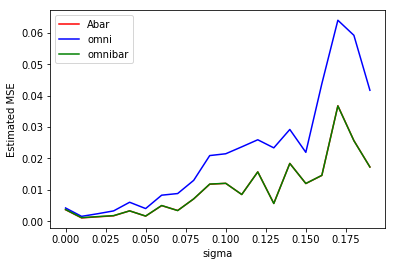

In [56]:
fig, ax = plt.subplots(1,1)
ax.plot(sigmas, abarMSE, label = 'Abar', c = 'r')
ax.plot(sigmas, omniMSE, label = 'omni', c = 'b')
ax.plot(sigmas, omnibarMSE, label = 'omnibar', c = 'g')
ax.legend(loc = 'upper left')
ax.set_xlabel('sigma')
ax.set_ylabel('Estimated MSE')

In [28]:
s

0.43